# Elo Merchant Category Recommendation

In [180]:
%matplotlib inline
import pandas as pd, numpy as np, scipy as sp, matplotlib.pyplot as plt, seaborn as sns


In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
merchants = pd.read_csv('data/merchants.csv')
historical_transactions = pd.read_csv('data/historical_transactions.csv', dtype={'category_1': 'category', 'category_2': 'category', 'category_3':'category', 'authorized_flag':'category'})
new_merchant_transactions = pd.read_csv('data/new_merchant_transactions.csv')

## Data Exploration

In [148]:
print('=================Training=================')
print(train.shape)
print()
print(train.head())
print()
print(train.info())
print('=================Testing=================')
print(test.shape)
print()
print(test.head())
print()
print(test.info())

=================Training=================
(201917, 6)

  first_active_month          card_id  feature_1  feature_2  feature_3  \
0            2017-06  C_ID_92a2005557          5          2          1   
1            2017-01  C_ID_3d0044924f          4          1          0   
2            2016-08  C_ID_d639edf6cd          2          2          0   
3            2017-09  C_ID_186d6a6901          4          3          0   
4            2017-11  C_ID_cdbd2c0db2          1          3          0   

     target  
0 -0.820283  
1  0.392913  
2  0.688056  
3  0.142495  
4 -0.159749  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null object
card_id               201917 non-null object
feature_1             201917 non-null int64
feature_2             201917 non-null int64
feature_3             201917 non-null int64
target                201917 non-null float64
dtypes: float64(1), int64(3), object

#### Target

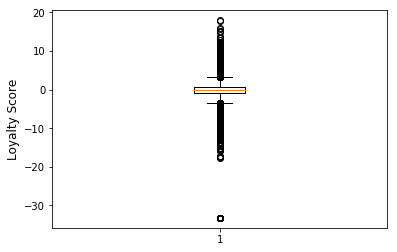

In [61]:
plt.boxplot(train.target)
plt.ylabel('Loyalty Score', fontsize=12)
plt.show()

In [23]:
train.target.quantile([0.1,0.25,0.5,0.75,0.9])

0.10   -2.042294
0.25   -0.883110
0.50   -0.023437
0.75    0.765453
0.90    1.830280
Name: target, dtype: float64

In [28]:
sum(train.target < -30)

2207

#### First active month

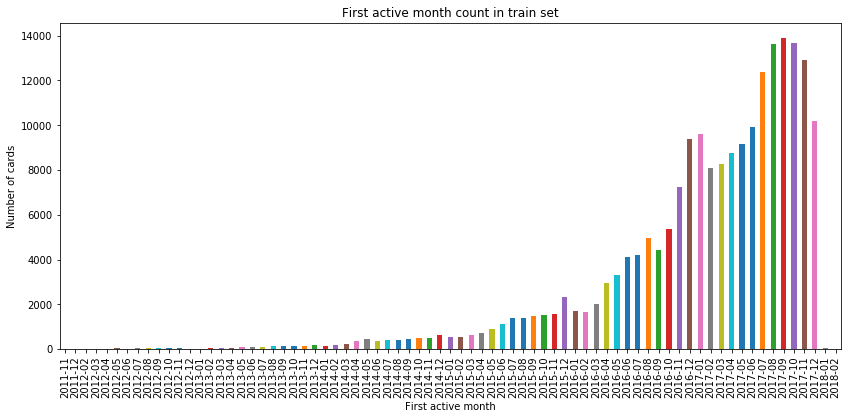

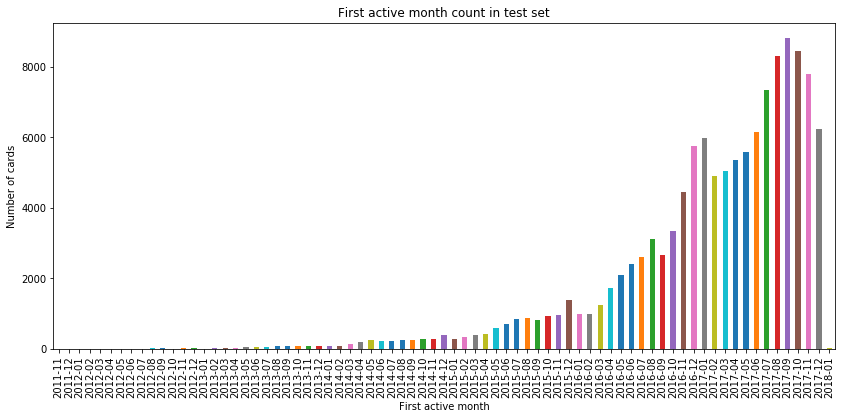

In [9]:
plt.figure(figsize=(14,6))
ax = train.first_active_month.value_counts().sort_index().plot(kind="bar")
plt.xlabel('First active month')
plt.ylabel('Number of cards')
plt.title("First active month count in train set")
plt.show()

plt.figure(figsize=(14,6))
ax = test.first_active_month.value_counts().sort_index().plot(kind="bar")
plt.xlabel('First active month')
plt.ylabel('Number of cards')
plt.title("First active month count in test set")
plt.show()

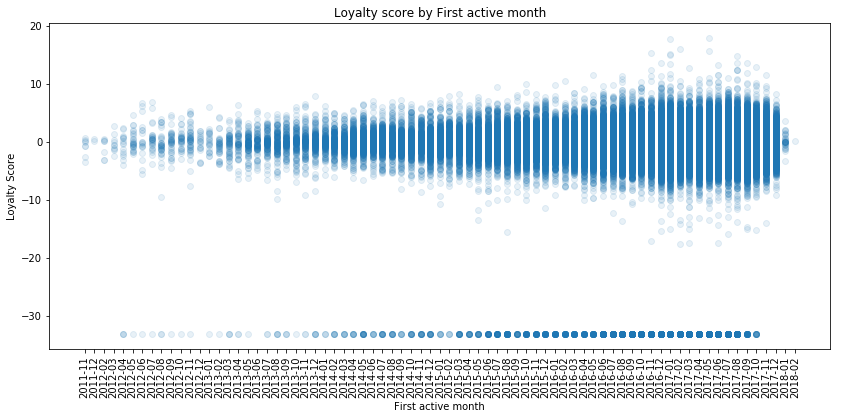

In [10]:
plt.figure(figsize=(14,6))
plt.scatter(train.sort_values('first_active_month').first_active_month, train.sort_values('first_active_month').target, alpha=0.1)
plt.xticks(rotation='vertical')
plt.xlabel('First active month')
plt.ylabel('Loyalty Score')
plt.title("Loyalty score by First active month")
plt.show()

#### Feature 1 2 3

[Text(0.5, 1.0, 'Loyalty score by feature')]

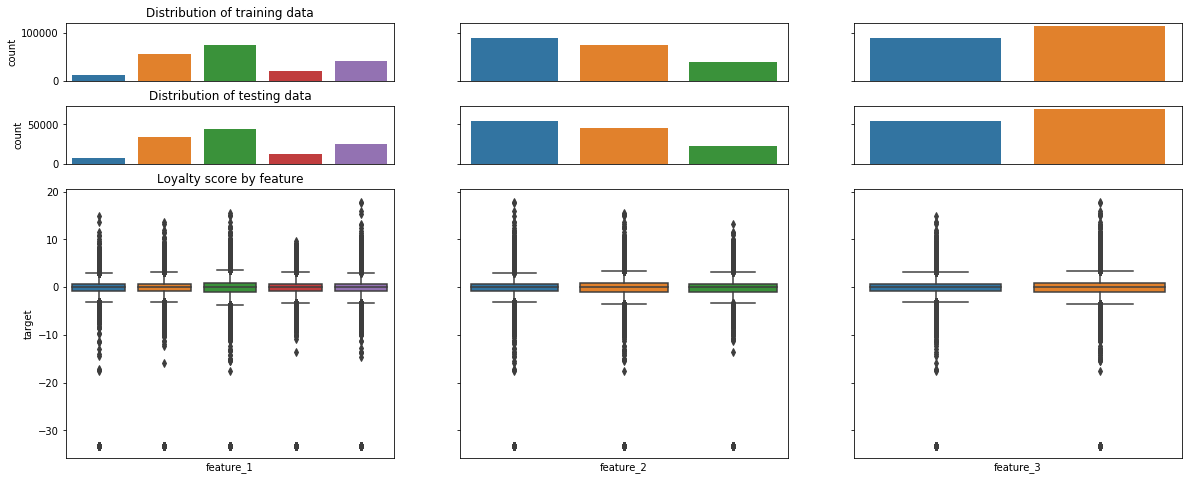

In [167]:
fig, axs = plt.subplots(3,3, figsize=(20,8),  gridspec_kw={"height_ratios": (.15, .15, .7)}, sharex='col', sharey='row')
for idx, feature in enumerate(['feature_1','feature_2','feature_3']):
    sns.boxplot(x=feature, y="target", data=train, ax=axs[2][idx])
    sns.countplot(x=feature, data=train, ax=axs[0][idx])
    sns.countplot(x=feature, data=test, ax=axs[1][idx])
    axs[0][idx].set(xlabel='', xticks=[])
    axs[1][idx].set(xlabel='', xticks=[])
    if idx > 0:
        axs[0][idx].set(ylabel='')
        axs[1][idx].set(ylabel='')
        axs[2][idx].set(ylabel='')
axs[0][0].set(title='Distribution of training data')
axs[1][0].set(title='Distribution of testing data')
axs[2][0].set(title='Loyalty score by feature')


The distribution of all 3 features are similar across training and testing set.  
And seems no significant relationship between any feature and loyalty score.

#### Historical transactions

In [183]:
historical_transactions['train'] = 'Y'
historical_transactions.loc[~historical_transactions.card_id.isin(train.card_id),'train'] = 'N'

In [166]:
print(historical_transactions.head())
print(historical_transactions.isnull().sum())

  authorized_flag          card_id  city_id category_1  installments  \
0               Y  C_ID_4e6213e9bc       88          N             0   
1               Y  C_ID_4e6213e9bc       88          N             0   
2               Y  C_ID_4e6213e9bc       88          N             0   
3               Y  C_ID_4e6213e9bc       88          N             0   
4               Y  C_ID_4e6213e9bc       88          N             0   

  category_3  merchant_category_id      merchant_id  month_lag  \
0          A                    80  M_ID_e020e9b302         -8   
1          A                   367  M_ID_86ec983688         -7   
2          A                    80  M_ID_979ed661fc         -6   
3          A                   560  M_ID_e6d5ae8ea6         -5   
4          A                    80  M_ID_e020e9b302        -11   

   purchase_amount        purchase_date  category_2  state_id  subsector_id  \
0        -0.703331  2017-06-25 15:33:07         1.0        16            37   
1        -0.

authorized_flag               0
card_id                       0
city_id                       0
category_1                    0
installments                  0
category_3               178159
merchant_category_id          0
merchant_id              138481
month_lag                     0
purchase_amount               0
purchase_date                 0
category_2              2652864
state_id                      0
subsector_id                  0
train                         0
dtype: int64


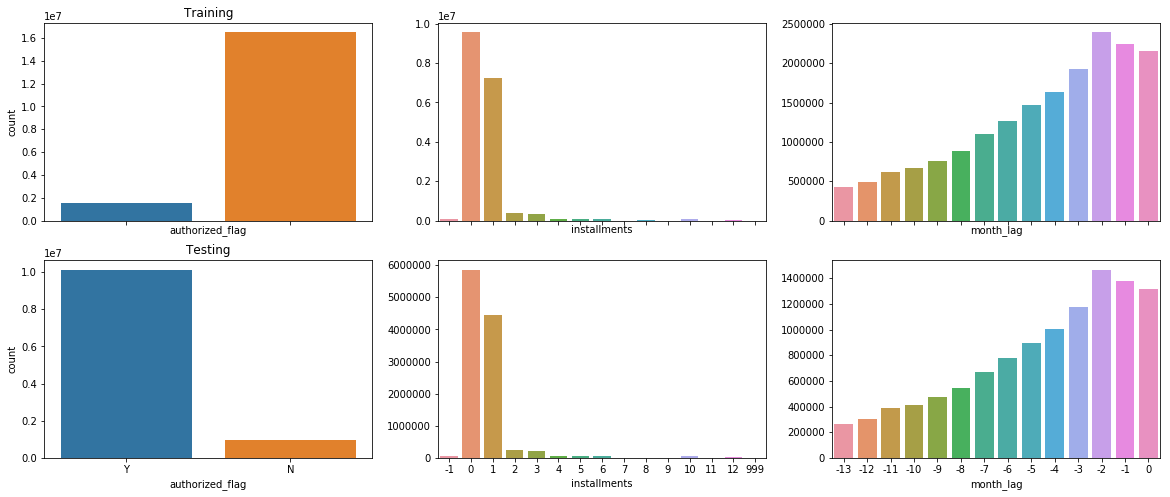

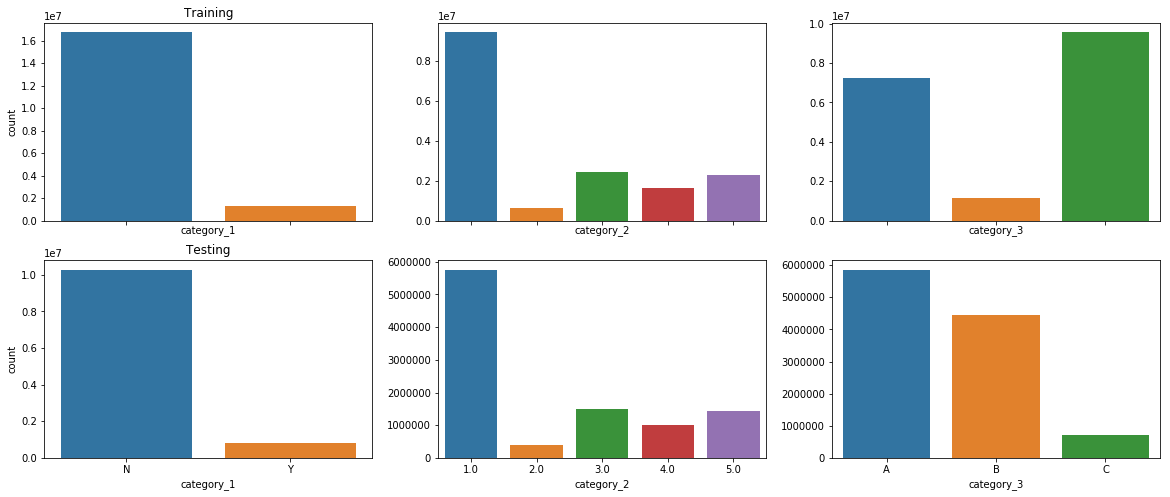

In [170]:
for feature_list in [['authorized_flag','installments','month_lag'],['category_1','category_2','category_3']]:
    fig, axs = plt.subplots(2, len(feature_list), figsize=(20,8),  gridspec_kw={"height_ratios": (.5,.5)}, sharex='col')
    for idx, feature in enumerate(feature_list):
        sns.countplot(x=feature, data=historical_transactions.loc[historical_transactions.train=='Y'], ax=axs[0][idx])
        sns.countplot(x=feature, data=historical_transactions.loc[historical_transactions.train=='N'], ax=axs[1][idx])
        #axs[0][idx].set(xlabel='', xticks=[])
        if idx > 0:
            axs[0][idx].set(ylabel='')
            axs[1][idx].set(ylabel='')
    axs[0][0].set(title='Training')
    axs[1][0].set(title='Testing')

#### First active month

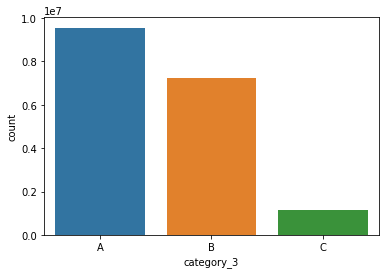

In [185]:
sns.countplot(x='category_3', data=historical_transactions.loc[historical_transactions.train=='Y'])


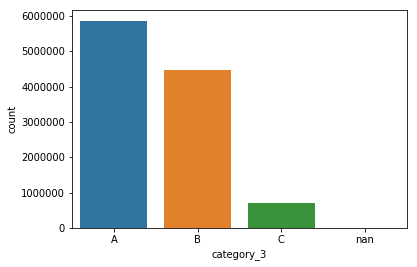

In [174]:
sns.countplot(x='category_3', data=historical_transactions.loc[historical_transactions.train=='N'], order=historical_transactions.category_3.unique())